In [24]:
import pandas as pd
import numpy as np
import sklearn

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

    Index(['aged_writeoff_amt', 'active', 'principal_amt_chrg_off',
           'writeoff_type_null', 'fee_reversals', 'total_writeoff_amt',
           'M_FLBT.IUSA', 'M_FCBC.IUSA', 'bank_fico_buckets_20_<= 560',
           'M_FHST.IUSA', 'M_FIFR_FEDS.IUSA', 'M_FIFR$_FEDS.IUSA',
           'charge_off_aged', 'fc_reversals', 'M_FIP.IUSA'],
          dtype='object')

In [67]:
col_dtypes = {
    "active": np.int8,
    "charge_off": np.int8,
    "charge_off_aged": np.int8,
    "principal_amt_chrg_off": np.float32,
    "total_writeoff_amt": np.float32,
    "aged_writeoff_amt": np.float32,
    "fc_reversals": np.float32,
    "fee_reversals": np.float32,
    "writeoff_type_bko": np.int8,
    "writeoff_type_fraud_kiting": np.int8,
    "writeoff_type_fraud_synthetic": np.int8,
    "writeoff_type_deceased": np.int8,
    "writeoff_type_other": np.int8,
    "writeoff_type_aged": np.int8,
    "writeoff_type_settlement": np.int8,
    "writeoff_type_fraud_other": np.int8,
    "writeoff_type_repo": np.int8,
    "writeoff_type_null": np.int8,
    "month": np.int8,
    "bank_fico_buckets_20_561-580": np.int8,
    "bank_fico_buckets_20_581-600": np.int8,
    "bank_fico_buckets_20_601-620": np.int8,
    "bank_fico_buckets_20_621-640": np.int8,
    "bank_fico_buckets_20_641-660": np.int8,
    "bank_fico_buckets_20_661-680": np.int8,
    "bank_fico_buckets_20_681-700": np.int8,
    "bank_fico_buckets_20_701-720": np.int8,
    "bank_fico_buckets_20_721-740": np.int8,
    "bank_fico_buckets_20_741-760": np.int8,
    "bank_fico_buckets_20_761+": np.int8,
    "bank_fico_buckets_20_<= 560": np.int8,
    "bank_fico_buckets_20_Exception": np.int8,
    "bank_fico_buckets_20_Missing": np.int8, 
    'M_FLBT.IUSA': np.float32,
    'M_FHST.IUSA': np.float32,
    'M_FCBC.IUSA': np.float32,
    'M_FIP.IUSA': np.float32,
    'M_FIFR_FEDS.IUSA': np.float32,
    'M_FIFR$_FEDS.IUSA': np.float32    
}

In [68]:
df = pd.read_csv("training_data_full.csv", dtype=col_dtypes, usecols=list(col_dtypes.keys()))

In [69]:
df.shape

(5758219, 39)

In [70]:
X = df.drop(["charge_off", "month"], axis=1)
# y = df[["charge_off", "month"]]
y = [(a, b) for a, b in zip(df['charge_off'].astype(bool), df['month'])]
y = np.array(y, dtype=[('charge_off','?'),('month','<f8')])

random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.998, random_state=random_state, stratify=df["charge_off"])

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.75, random_state=random_state, stratify=y_train["charge_off"])

In [33]:
param_vals_vec = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
train_score_vec = np.zeros(len(param_vals_vec))
test_score_vec = np.zeros(len(param_vals_vec))
# train_rmse_vec = np.zeros(len(param_vals_vec))
# test_rmse_vec = np.zeros(len(param_vals_vec))

for i, param_val in enumerate(param_vals_vec):
    print("Start learning_rate =", param_val)
    gbm_temp = GradientBoostingSurvivalAnalysis(
        n_estimators=500, random_state=42, learning_rate=param_val, verbose=1
    )
    gbm_temp.fit(X_train, y_train)
    train_preds = gbm_temp.predict(X_test)
    train_score_vec[i] = gbm_temp.score(X_train, y_train)
    test_score_vec[i] = gbm_temp.score(X_test, y_test)
    

Start learning_rate = 0.0001
      Iter       Train Loss   Remaining Time 
         1          53.7498           51.29s
         2          53.7490           47.72s
         3          53.7482           48.34s
         4          53.7474           45.11s
         5          53.7466           45.91s
         6          53.7458           44.11s
         7          53.7450           46.48s
         8          53.7442           47.98s
         9          53.7434           47.37s
        10          53.7426           47.46s
        20          53.7347           44.54s
        30          53.7267           44.58s
        40          53.7188           44.83s
        50          53.7108           42.57s
        60          53.7029           42.12s
        70          53.6950           40.63s
        80          53.6870           39.44s
        90          53.6791           38.50s
       100          53.6711           37.79s
       200          53.5917           28.36s
       300          53.51

        10          52.1633           48.53s
        20          50.5801           42.33s
        30          49.0017           42.71s
        40          47.4291           43.82s
        50          45.8636           42.62s
        60          44.3064           42.31s
        70          42.7590           40.60s
        80          41.2233           40.02s
        90          39.7013           38.54s
       100          38.1952           37.24s
       200          24.6199           26.85s
       300          15.3752           18.08s
       400          10.4140            9.29s
       500           7.8398            0.00s
Start learning_rate = 0.05
      Iter       Train Loss   Remaining Time 
         1          53.3534           50.00s
         2          52.9564           42.88s
         3          52.5597           41.12s
         4          52.1632           39.72s
         5          51.7669           41.34s
         6          51.3709           42.61s
         7          50.9752

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(param_vals_vec, train_score_vec, marker="x", label="train")
plt.plot(param_vals_vec, test_score_vec, marker="x", label="test")
plt.legend(loc="lower right")
plt.xlabel("learning rate")
plt.ylabel("Concordance")
plt.show()

In [37]:
param_vals_vec = np.arange(1, 10)
train_score_vec = np.zeros(len(param_vals_vec))
test_score_vec = np.zeros(len(param_vals_vec))
# train_rmse_vec = np.zeros(len(param_vals_vec))
# test_rmse_vec = np.zeros(len(param_vals_vec))

for i, param_val in enumerate(param_vals_vec):
    print("Start max_depth =", param_val)
    gbm_temp = GradientBoostingSurvivalAnalysis(
        n_estimators=500, max_depth=param_val, random_state=42, learning_rate=0.01, verbose=1
    )
    gbm_temp.fit(X_train, y_train)
    train_preds = gbm_temp.predict(X_test)
    train_score_vec[i] = gbm_temp.score(X_train, y_train)
    test_score_vec[i] = gbm_temp.score(X_test, y_test)

Start max_depth = 1
      Iter       Train Loss   Remaining Time 
         1          53.6712           52.30s
         2          53.5918            1.09m
         3          53.5125            1.07m
         4          53.4332            1.06m
         5          53.3538            1.10m
         6          53.2745            1.10m
         7          53.1952            1.11m
         8          53.1159            1.12m
         9          53.0366            1.14m
        10          52.9573            1.14m
        20          52.1650            1.04m
        30          51.3737           57.33s
        40          50.5835           58.45s
        50          49.7945           55.72s
        60          49.0069           53.49s
        70          48.2209           52.15s
        80          47.4364           52.25s
        90          46.6538           51.15s
       100          45.8732           50.58s
       200          38.2281           40.49s
       300          31.1238       

        20          52.1630           55.23s
        30          51.3707           58.90s
        40          50.5794            1.00m
        50          49.7894           59.66s
        60          49.0008           59.62s
        70          48.2135           58.62s
        80          47.4279           56.97s
        90          46.6440           55.41s
       100          45.8621           54.24s
       200          38.1925           40.42s
       300          30.9927           27.10s
       400          24.6102           13.68s
       500          19.3485            0.00s
Start max_depth = 9
      Iter       Train Loss   Remaining Time 
         1          53.6711            1.31m
         2          53.5916            1.16m
         3          53.5122            1.19m
         4          53.4328            1.14m
         5          53.3533            1.18m
         6          53.2739            1.20m
         7          53.1945            1.15m
         8          53.1151       

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(param_vals_vec, train_score_vec, marker="x", label="train")
plt.plot(param_vals_vec, test_score_vec, marker="x", label="test")
plt.legend(loc="lower right")
plt.xlabel("Max Depth")
plt.ylabel("Concordance")
plt.show()

## hyperopt

In [71]:
def eval_model(params):
    gbm_temp = GradientBoostingSurvivalAnalysis()
    gbm_temp.set_params(**params, random_state=42)
    gbm_temp.fit(X_train, y_train)
    acc = gbm_temp.score(X_test, y_test)
    return(-acc)

In [72]:
fspace = {
    'learning_rate': hp.loguniform('learning_rate', -10, -1),
    'max_depth': hp.randint('max_depth', 1, 20),
    'min_samples_leaf': hp.loguniform('min_samples_leaf', -10, -2),
    'n_estimators': hp.randint('n_estimators', 50, 1000)
}

In [73]:
trials = Trials()
best = fmin(fn=eval_model, space=fspace, algo=tpe.suggest, max_evals=10, trials=trials)

100%|███████████████████████████████████████████████| 10/10 [11:43<00:00, 70.39s/trial, best loss: -0.9993110814419226]


In [74]:
best

{'learning_rate': 0.0016938263864616945,
 'max_depth': 11,
 'min_samples_leaf': 9.965201247882815e-05,
 'n_estimators': 281}

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

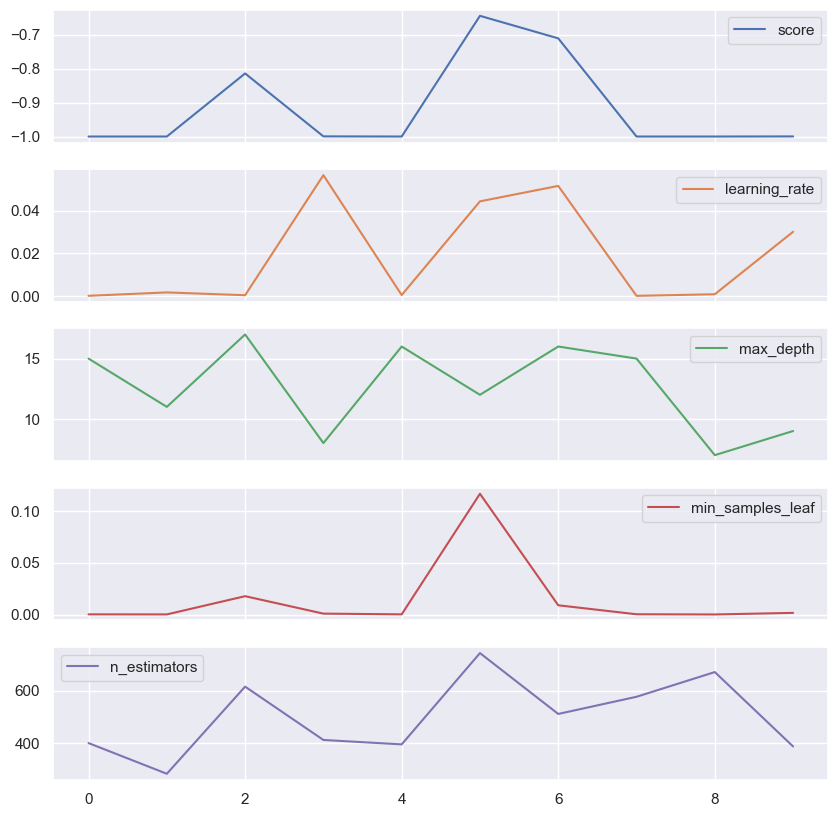

In [75]:
results = np.array([[x['result']['loss'],
                    x['misc']['vals']['learning_rate'][0],
                    x['misc']['vals']['max_depth'][0],
                    x['misc']['vals']['min_samples_leaf'][0],
                    x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

results_df = pd.DataFrame(results, columns=['score', 'learning_rate', 'max_depth', 'min_samples_leaf', 'n_estimators'])
results_df.plot(subplots=True, figsize=(10, 10))

In [76]:
params = best
gbm = GradientBoostingSurvivalAnalysis()
gbm.set_params(**params, random_state=42)
gbm.fit(X_train, y_train)
acc = gbm.score(X_test, y_test)
acc

0.9993110814419226

In [77]:
selected_forecast_starting_data = pd.read_csv("selected_forecast_starting_data.csv")

In [78]:
selected_forecast_starting_data

aged_writeoff_amt  active  principal_amt_chrg_off  fee_reversals  \
0                    0.0       1                     0.0            0.0   
1                    0.0       1                     0.0            0.0   
2                    0.0       1                     0.0            0.0   
3                    0.0       1                     0.0            0.0   
4                    0.0       1                     0.0            0.0   
...                  ...     ...                     ...            ...   
19861                0.0       1                     0.0            0.0   
19862                0.0       1                     0.0            0.0   
19863                0.0       1                     0.0            0.0   
19864                0.0       1                     0.0            0.0   
19865                0.0       1                     0.0            0.0   

       total_writeoff_amt  M_FLBT.IUSA  M_FCBC.IUSA  \
0                     0.0         63.4        130.4   
1                     0.0         63.4        130.4   
2                     0.0         63.4        130.4   
3                     0.0         63.4        130.4   
4                     0.0         63.4        130.4   
...                   ...          ...          ...   
19861                 0.0         63.4        130.4   
19862                 0.0         63.4        130.4   
19863                 0.0         63.4        130.4   
19864                 0.0         63.4        130.4   
19865                 0.0         63.4        130.4   

       bank_fico_buckets_20_561-580  bank_fico_buckets_20_581-600  \
0                               0.0                           0.0   
1                               0.0                           0.0   
2                               0.0                           0.0   
3                               0.0                           0.0   
4                               0.0                           0.0   
...                             ...                           ...   
19861                           0.0                           0.0   
19862                           0.0                           0.0   
19863                           0.0                           0.0   
19864                           0.0                           0.0   
19865                           0.0                           0.0   

       bank_fico_buckets_20_601-620  ...  writeoff_type_bko  \
0                               0.0  ...                  0   
1                               0.0  ...                  0   
2                               0.0  ...                  0   
3                               0.0  ...                  0   
4                               0.0  ...                  0   
...                             ...  ...                ...   
19861                           0.0  ...                  0   
19862                           0.0  ...                  0   
19863                           0.0  ...                  0   
19864                           0.0  ...                  0   
19865                           0.0  ...                  0   

       writeoff_type_fraud_kiting  writeoff_type_fraud_synthetic  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
...                           ...                            ...   
19861                           0                              0   
19862                           0                              0   
19863                           0                              0   
19864                           0                              0   
19865                           0                              0   

       writeoff_type_deceased  writeoff_ty

In [81]:
selected_forecast_starting_data = selected_forecast_starting_data[list(X_train.columns)]

In [82]:
predict_survival_function = gbm.predict_survival_function(selected_forecast_starting_data)

In [83]:
def add_prob(i):
    n = len(predict_survival_function)
    sum_prob = 0
    for j in range(n):
        sum_prob = sum_prob + predict_survival_function[j](i)
    return n-int(sum_prob)

In [84]:
charoff_number = {}
for i in range(1,13):
    if i <12:
        charoff_number.update({i+202001:add_prob(i)})
    else:
        charoff_number.update({202101:add_prob(i)})

In [85]:
pred = pd.DataFrame(charoff_number.items(), columns = ["Month", "accounts_charged_off"])

In [86]:
pred

Month  accounts_charged_off
0   202002                     8
1   202003                    16
2   202004                    25
3   202005                    35
4   202006                    35
5   202007                    35
6   202008                    35
7   202009                    35
8   202010                    35
9   202011                    35
10  202012                    58
11  202101                    58

In [88]:
ft_imp = pd.Series(gbm.feature_importances_, index=X_train.columns).sort_values(ascending=False)
ft_imp[0:20]

writeoff_type_null              0.227485
active                          0.206105
total_writeoff_amt              0.198983
principal_amt_chrg_off          0.184833
writeoff_type_aged              0.181307
M_FIFR_FEDS.IUSA                0.000964
M_FIFR$_FEDS.IUSA               0.000070
M_FIP.IUSA                      0.000036
bank_fico_buckets_20_<= 560     0.000035
bank_fico_buckets_20_761+       0.000025
M_FCBC.IUSA                     0.000023
bank_fico_buckets_20_621-640    0.000021
M_FHST.IUSA                     0.000017
bank_fico_buckets_20_641-660    0.000015
bank_fico_buckets_20_601-620    0.000015
M_FLBT.IUSA                     0.000014
aged_writeoff_amt               0.000012
bank_fico_buckets_20_661-680    0.000012
bank_fico_buckets_20_741-760    0.000006
bank_fico_buckets_20_721-740    0.000005
dtype: float64

In [89]:
import shap

In [93]:
explainer = shap.Explainer(gbm.predict, X_train)

In [97]:
shap_values = explainer(X_train)

Permutation explainer: 2880it [38:08,  1.25it/s]                                                                       


In [109]:
np.shape(shap_values)

(2879, 37)

In [111]:
shap.summary_plot(shap_values, X_train)

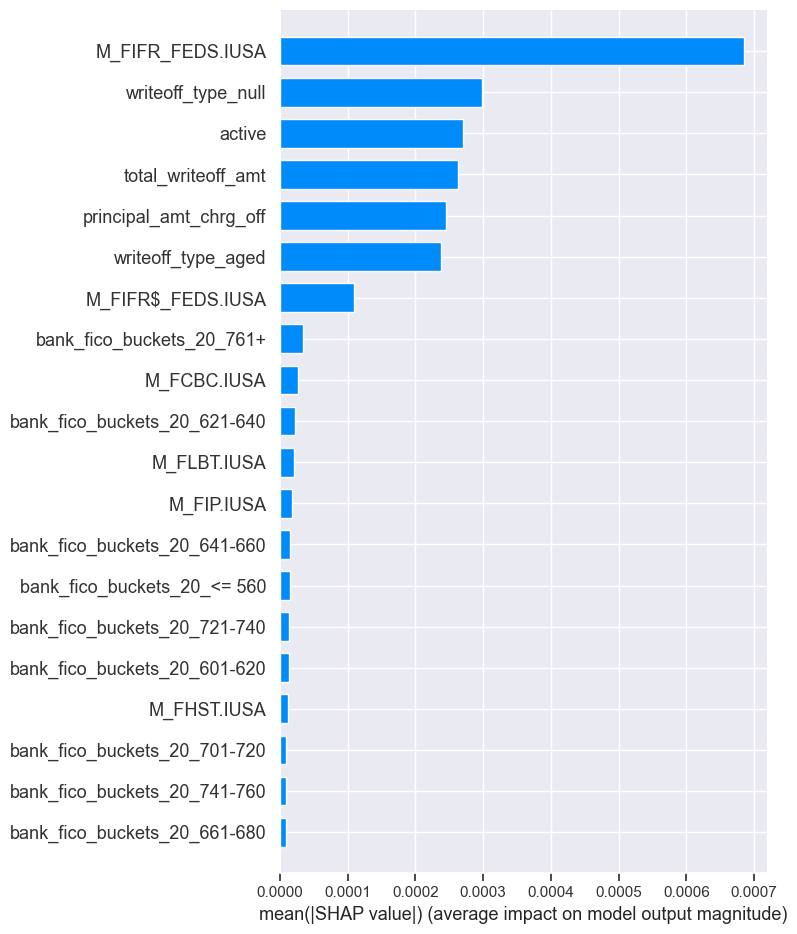

In [102]:
plt.figure(figsize=(6, 12))
shap.summary_plot(shap_values, X_train.values, 
                 plot_type="bar", feature_names=X_train.columns, class_names=[0, 1],
                 class_inds="original")

In [126]:
shap.plots.waterfall(shap_values[9])